In [1]:
%load_ext autoreload
%autoreload 2

from scipy import signal
import numpy as np
from scipy.fftpack import fft, ifft
import pandas as pd

import matplotlib
matplotlib.use('nbagg')
from pylab import rcParams
rcParams['figure.figsize'] = 9, 4
import matplotlib.pyplot as plt
import scipy


from pyha import Hardware, simulate, sims_close, Complex, resize, hardware_sims_equal
from pyha.common.util import *
from pyha.common.float import *

# FIR tests

In [2]:
class FIRFloat(Hardware):
    def __init__(self, taps):
        self.DELAY = 2

        self.TAPS = [Float(x) for x in np.array(taps).tolist()]
#         self.TAPS = np.array(taps).tolist()
        self.TAPS_ORIG = taps

        # registers
        self.acc = [Float()] * len(taps)
        self.mul = [Float()] * len(taps)
        # self.out = Float()

    def main(self, x):
        """ Transposed FIR structure """
        self.acc[0] = x * self.TAPS[-1]
        for i in range(1, len(self.acc)):
            self.mul[i] = x * self.TAPS[len(self.TAPS) - 1 - i]
            self.acc[i] = self.acc[i - 1] + self.mul[i]

        return self.acc[-1]

    def model_main(self, x):
        return signal.lfilter(self.TAPS_ORIG, [1.0], x)

In [3]:
np.random.seed(0)
taps = signal.remez(128, [0, 0.1, 0.155, 0.5], [1, 0])
# taps = signal.remez(511, [0, 0.4/2, 0.43/2, 1.0/2], [1, 0])
# taps = np.random.uniform(-1, 1, 256)
inp = np.random.uniform(-1, 1, 1024) / 2 /2 / 2 / 2 / 2 / 2 / 2
# inp = np.random.normal(scale=32, size=1024)

<IPython.core.display.Javascript object>


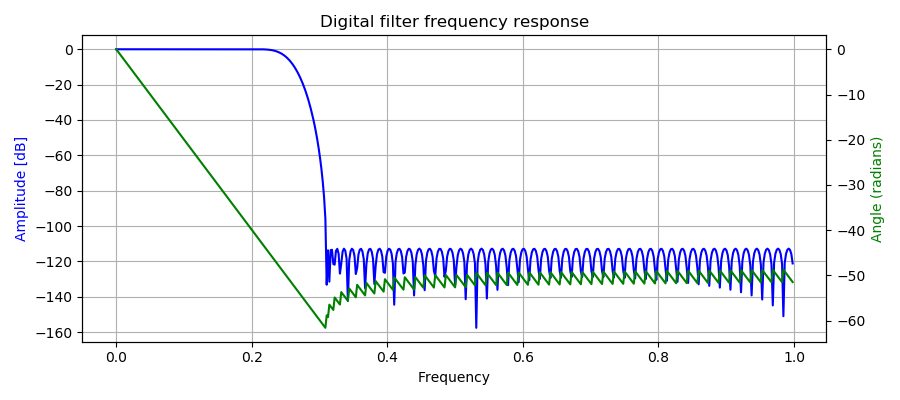

<IPython.core.display.Javascript object>


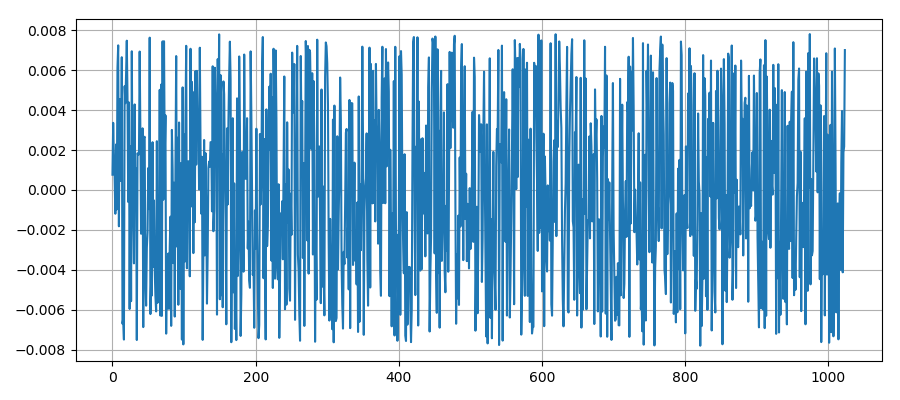

In [4]:
def show_freqz(taps):
    w, h = scipy.signal.freqz(taps)
    fig, ax1 = plt.subplots(1, 1)
    plt.title('Digital filter frequency response')
    ax1.plot(w / np.pi, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency')
    plt.grid()
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w / np.pi, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.axis('tight')
    plt.tight_layout()
    plt.show()
    
show_freqz(taps)

plt.plot(inp)
show_plot()

In [5]:
results = {}

with force_format(radix=32, exponent_bits=3, fractional_bits=14):
    dut = FIRFloat(taps)
    sims = simulate(dut, inp, input_types=[Float()], simulations=['MODEL', 'PYHA'])
    results['Float64'] = np.array([float(x) for x in sims['MODEL']])
    results['Radix32'] = np.array([float(x) for x in sims['PYHA']])
#     results['RTL'] = np.array([float(x) for x in sims['RTL']])

with force_format(radix=16, exponent_bits=4, fractional_bits=13):
    dut = FIRFloat(taps)
    sims = simulate(dut, inp, input_types=[Float()], simulations=['PYHA'])
    results['Radix16'] = np.array([float(x) for x in sims['PYHA']])

with force_format(float16_mode=True):
    dut = FIRFloat(taps)
    sims = simulate(dut, inp, input_types=[Float()], simulations=['PYHA'])
    results['Float16'] = np.array([float(x) for x in sims['PYHA']])

INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


  0%|          | 0/1026 [00:00<?, ?it/s]

  1%|          | 7/1026 [00:00<00:17, 58.91it/s]

  1%|▏         | 14/1026 [00:00<00:16, 61.54it/s]

  2%|▏         | 22/1026 [00:00<00:15, 63.58it/s]

  3%|▎         | 29/1026 [00:00<00:16, 61.52it/s]

  4%|▎         | 36/1026 [00:00<00:16, 61.49it/s]

  4%|▍         | 43/1026 [00:00<00:15, 61.79it/s]

  5%|▍         | 51/1026 [00:00<00:15, 63.25it/s]

  6%|▌         | 59/1026 [00:00<00:15, 64.06it/s]

  6%|▋         | 66/1026 [00:01<00:14, 64.64it/s]

  7%|▋         | 73/1026 [00:01<00:14, 64.89it/s]

  8%|▊         | 81/1026 [00:01<00:14, 65.85it/s]

  9%|▊         | 88/1026 [00:01<00:14, 64.68it/s]

  9%|▉         | 95/1026 [00:01<00:14, 64.66it/s]

 10%|█         | 103/1026 [00:01<00:14, 65.37it/s]

 11%|█         | 110/1026 [00:01<00:14, 64.75it/s]

 11%|█▏        | 117/1026 [00:01<00:13, 65.04it/s]

 12%|█▏        | 124/1026 [00:01<00:14, 64.02it/s]

 13%|█▎        | 131/1026 [00:02<00:13, 64.25it/s]

 13%|█▎        | 138/1026 [00:02<00:13, 63.95it/s]

 14%|█▍        | 145/1026 [00:02<00:13, 63.89it/s]

 15%|█▍        | 153/1026 [00:02<00:13, 64.17it/s]

 16%|█▌        | 161/1026 [00:02<00:13, 64.54it/s]

 16%|█▋        | 169/1026 [00:02<00:13, 65.04it/s]

 17%|█▋        | 177/1026 [00:02<00:12, 65.33it/s]

 18%|█▊        | 185/1026 [00:02<00:12, 65.75it/s]

 19%|█▉        | 193/1026 [00:02<00:12, 65.64it/s]

 19%|█▉        | 200/1026 [00:03<00:12, 65.48it/s]

 20%|██        | 208/1026 [00:03<00:12, 65.59it/s]

 21%|██        | 215/1026 [00:03<00:12, 65.61it/s]

 22%|██▏       | 223/1026 [00:03<00:12, 65.81it/s]

 23%|██▎       | 231/1026 [00:03<00:12, 65.95it/s]

 23%|██▎       | 238/1026 [00:03<00:11, 65.78it/s]

 24%|██▍       | 245/1026 [00:03<00:11, 65.82it/s]

 25%|██▍       | 252/1026 [00:03<00:11, 65.66it/s]

 25%|██▌       | 260/1026 [00:03<00:11, 65.85it/s]

 26%|██▌       | 268/1026 [00:04<00:11, 66.11it/s]

 27%|██▋       | 275/1026 [00:04<00:11, 66.10it/s]

 28%|██▊       | 283/1026 [00:04<00:11, 66.39it/s]

 28%|██▊       | 291/1026 [00:04<00:11, 66.17it/s]

 29%|██▉       | 298/1026 [00:04<00:10, 66.21it/s]

 30%|██▉       | 305/1026 [00:04<00:10, 66.16it/s]

 31%|███       | 313/1026 [00:04<00:10, 66.31it/s]

 31%|███       | 320/1026 [00:04<00:10, 66.38it/s]

 32%|███▏      | 327/1026 [00:04<00:10, 66.42it/s]

 33%|███▎      | 335/1026 [00:05<00:10, 66.63it/s]

 33%|███▎      | 343/1026 [00:05<00:10, 66.65it/s]

 34%|███▍      | 350/1026 [00:05<00:10, 66.47it/s]

 35%|███▍      | 357/1026 [00:05<00:10, 66.17it/s]

 35%|███▌      | 364/1026 [00:05<00:09, 66.22it/s]

 36%|███▌      | 371/1026 [00:05<00:09, 66.01it/s]

 37%|███▋      | 378/1026 [00:05<00:09, 65.96it/s]

 38%|███▊      | 385/1026 [00:05<00:09, 65.93it/s]

 38%|███▊      | 392/1026 [00:05<00:09, 65.94it/s]

 39%|███▉      | 400/1026 [00:06<00:09, 66.06it/s]

 40%|███▉      | 408/1026 [00:06<00:09, 66.22it/s]

 41%|████      | 416/1026 [00:06<00:09, 66.34it/s]

 41%|████▏     | 424/1026 [00:06<00:09, 66.50it/s]

 42%|████▏     | 432/1026 [00:06<00:08, 66.30it/s]

 43%|████▎     | 439/1026 [00:06<00:08, 66.23it/s]

 44%|████▎     | 447/1026 [00:06<00:08, 66.44it/s]

 44%|████▍     | 456/1026 [00:06<00:08, 66.71it/s]

 45%|████▌     | 464/1026 [00:06<00:08, 66.73it/s]

 46%|████▌     | 472/1026 [00:07<00:08, 66.63it/s]

 47%|████▋     | 480/1026 [00:07<00:08, 66.69it/s]

 47%|████▋     | 487/1026 [00:07<00:08, 66.67it/s]

 48%|████▊     | 494/1026 [00:07<00:07, 66.70it/s]

 49%|████▉     | 501/1026 [00:07<00:07, 66.45it/s]

 50%|████▉     | 509/1026 [00:07<00:07, 66.53it/s]

 50%|█████     | 516/1026 [00:07<00:07, 66.56it/s]

 51%|█████     | 524/1026 [00:07<00:07, 66.64it/s]

 52%|█████▏    | 532/1026 [00:07<00:07, 66.73it/s]

 53%|█████▎    | 540/1026 [00:08<00:07, 66.77it/s]

 53%|█████▎    | 547/1026 [00:08<00:07, 66.80it/s]

 54%|█████▍    | 554/1026 [00:08<00:07, 66.64it/s]

 55%|█████▍    | 561/1026 [00:08<00:06, 66.65it/s]

 55%|█████▌    | 568/1026 [00:08<00:06, 66.53it/s]

 56%|█████▌    | 577/1026 [00:08<00:06, 66.71it/s]

 57%|█████▋    | 584/1026 [00:08<00:06, 66.67it/s]

 58%|█████▊    | 592/1026 [00:08<00:06, 66.78it/s]

 58%|█████▊    | 599/1026 [00:08<00:06, 66.69it/s]

 59%|█████▉    | 607/1026 [00:09<00:06, 66.77it/s]

 60%|█████▉    | 614/1026 [00:09<00:06, 66.52it/s]

 61%|██████    | 621/1026 [00:09<00:06, 66.43it/s]

 61%|██████▏   | 630/1026 [00:09<00:05, 66.59it/s]

 62%|██████▏   | 637/1026 [00:09<00:05, 66.53it/s]

 63%|██████▎   | 645/1026 [00:09<00:05, 66.60it/s]

 64%|██████▎   | 652/1026 [00:09<00:05, 66.47it/s]

 64%|██████▍   | 659/1026 [00:09<00:05, 66.50it/s]

 65%|██████▍   | 666/1026 [00:10<00:05, 66.49it/s]

 66%|██████▌   | 674/1026 [00:10<00:05, 66.54it/s]

 66%|██████▋   | 681/1026 [00:10<00:05, 66.52it/s]

 67%|██████▋   | 688/1026 [00:10<00:05, 66.51it/s]

 68%|██████▊   | 695/1026 [00:10<00:04, 66.51it/s]

 68%|██████▊   | 702/1026 [00:10<00:04, 66.50it/s]

 69%|██████▉   | 710/1026 [00:10<00:04, 66.59it/s]

 70%|██████▉   | 717/1026 [00:10<00:04, 66.50it/s]

 71%|███████   | 725/1026 [00:10<00:04, 66.54it/s]

 71%|███████▏  | 732/1026 [00:11<00:04, 66.47it/s]

 72%|███████▏  | 739/1026 [00:11<00:04, 66.37it/s]

 73%|███████▎  | 748/1026 [00:11<00:04, 66.48it/s]

 74%|███████▎  | 755/1026 [00:11<00:04, 66.28it/s]

 74%|███████▍  | 762/1026 [00:11<00:03, 66.30it/s]

 75%|███████▍  | 769/1026 [00:11<00:03, 66.29it/s]

 76%|███████▌  | 776/1026 [00:11<00:03, 66.29it/s]

 76%|███████▋  | 783/1026 [00:11<00:03, 66.14it/s]

 77%|███████▋  | 791/1026 [00:11<00:03, 66.18it/s]

 78%|███████▊  | 798/1026 [00:12<00:03, 66.17it/s]

 78%|███████▊  | 805/1026 [00:12<00:03, 66.05it/s]

 79%|███████▉  | 812/1026 [00:12<00:03, 66.08it/s]

 80%|███████▉  | 820/1026 [00:12<00:03, 66.10it/s]

 81%|████████  | 827/1026 [00:12<00:03, 66.11it/s]

 81%|████████▏ | 835/1026 [00:12<00:02, 66.19it/s]

 82%|████████▏ | 842/1026 [00:12<00:02, 66.06it/s]

 83%|████████▎ | 849/1026 [00:12<00:02, 66.05it/s]

 83%|████████▎ | 856/1026 [00:12<00:02, 66.03it/s]

 84%|████████▍ | 863/1026 [00:13<00:02, 65.99it/s]

 85%|████████▍ | 870/1026 [00:13<00:02, 65.97it/s]

 85%|████████▌ | 877/1026 [00:13<00:02, 65.88it/s]

 86%|████████▋ | 885/1026 [00:13<00:02, 65.93it/s]

 87%|████████▋ | 892/1026 [00:13<00:02, 65.90it/s]

 88%|████████▊ | 899/1026 [00:13<00:01, 65.67it/s]

 88%|████████▊ | 907/1026 [00:13<00:01, 65.73it/s]

 89%|████████▉ | 916/1026 [00:13<00:01, 65.83it/s]

 90%|████████▉ | 923/1026 [00:14<00:01, 65.78it/s]

 91%|█████████ | 930/1026 [00:14<00:01, 65.76it/s]

 91%|█████████▏| 938/1026 [00:14<00:01, 65.82it/s]

 92%|█████████▏| 945/1026 [00:14<00:01, 65.80it/s]

 93%|█████████▎| 952/1026 [00:14<00:01, 65.83it/s]

 93%|█████████▎| 959/1026 [00:14<00:01, 65.77it/s]

 94%|█████████▍| 966/1026 [00:14<00:00, 65.78it/s]

 95%|█████████▍| 973/1026 [00:14<00:00, 65.79it/s]

 96%|█████████▌| 980/1026 [00:14<00:00, 65.60it/s]

 96%|█████████▌| 987/1026 [00:15<00:00, 65.51it/s]

 97%|█████████▋| 994/1026 [00:15<00:00, 65.50it/s]

 98%|█████████▊| 1001/1026 [00:15<00:00, 65.44it/s]

 98%|█████████▊| 1007/1026 [00:15<00:00, 65.35it/s]

 99%|█████████▉| 1014/1026 [00:15<00:00, 65.34it/s]

 99%|█████████▉| 1020/1026 [00:15<00:00, 65.28it/s]

100%|██████████| 1026/1026 [00:15<00:00, 65.25it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!
INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...



 12%|█▏        | 119/1026 [00:00<00:06, 142.61it/s]

 70%|███████   | 719/1026 [00:04<00:02, 145.00it/s]

 86%|████████▌ | 884/1026 [00:06<00:00, 145.03it/s]

100%|██████████| 1026/1026 [00:07<00:00, 145.09it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!
INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...



100%|██████████| 1026/1026 [00:02<00:00, 383.74it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


<IPython.core.display.Javascript object>


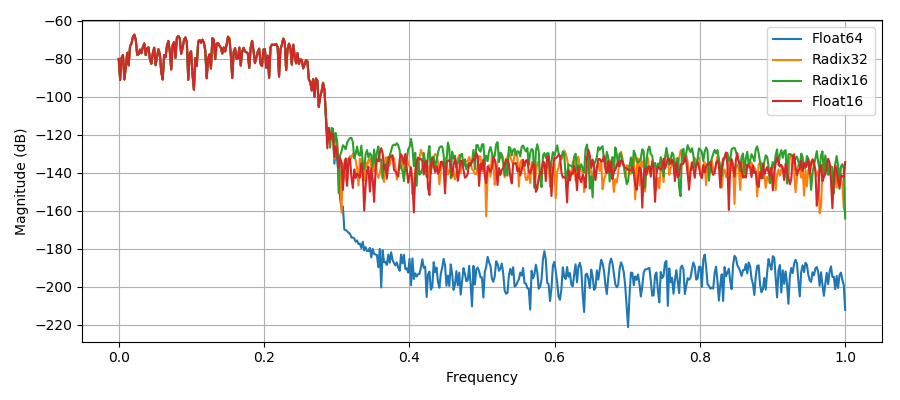

<IPython.core.display.Javascript object>


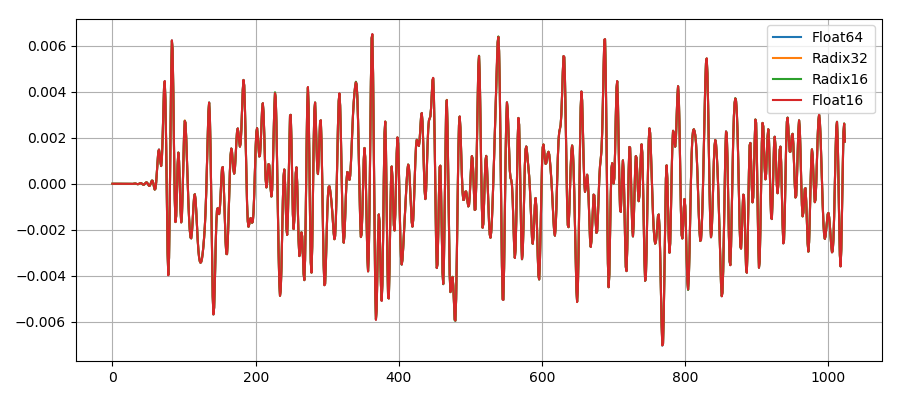

In [6]:
for key, val in results.items():
    plt.magnitude_spectrum(val, scale='dB', label=key)
show_plot()

for key, val in results.items():
    plt.plot(val, label=key)
show_plot()

<IPython.core.display.Javascript object>


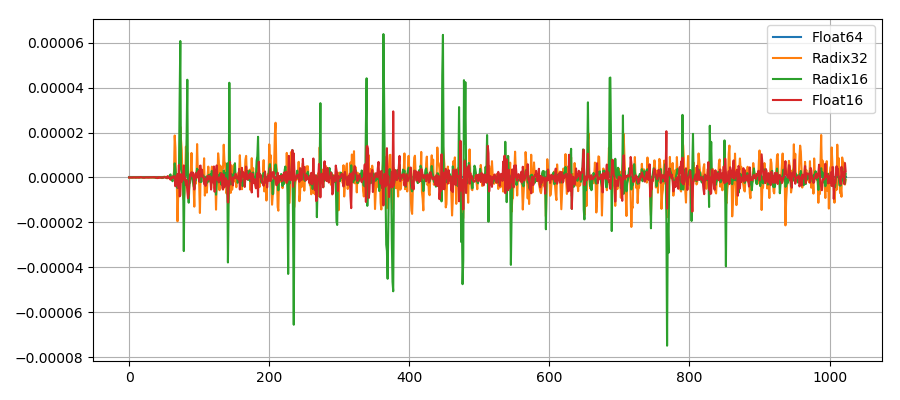

Float64 SNR: inf dB
Radix32 SNR: 52.34597487470723 dB
Radix16 SNR: 53.91774996462864 dB
Float16 SNR: 57.76928545755317 dB


/home/gaspar/git/pyha/pyha/common/util.py:109: RuntimeWarning: divide by zero encountered in double_scalars
  snr_db = 20 * np.log10(sig_pow / err_pow)


In [7]:
for key, val in results.items():
    plt.plot(results['Float64'] - val, label=key)
show_plot()

for key, val in results.items():
    print(f'{key} SNR: {snr(results["Float64"], val)} dB')
#     plt.plot(results['Float64'] - val, label=key)